In [2]:
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import roc_auc_score, mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [26]:
files = 'gs://hm-eu-w4/jigsaw/s08/*/params0.9*.csv'
candidates = sorted(tf.io.gfile.glob(files))

print(len(candidates))
candidates

9


['gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv',
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv']

In [27]:
# pd.read_csv('gs://hm-eu-w4/jigsaw/t12/20200429_202612_t8c/params0.962192.csv').T[0]

In [28]:
df = None

for f in candidates:
    score = float(os.path.basename(f)[6:-4])
    if score > 0.94:
        if df is None:
            df = pd.read_csv(f)
        else:
            df = df.append(pd.read_csv(f), ignore_index=True)

df.describe()

,auc,batch_size,div_factor,dropout,epochs,final_div_factor,gamma,label_smoothing,lr,max_len,mom_max,mom_min,pos_weight,seed,warm_up,weight_decay
count,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,6.000000,9.000000,9.000000,9.0,9.000000,9.000000,6.000000,9.000000,9.000000,9.000000e+00
mean,0.955914,24.666667,223.110466,0.261111,43.777778,1781.307300,1.389901,0.030910,0.000046,192.0,0.934825,0.845122,3.297741,422.555556,2.832312,6.926666e-06
std,0.000520,1.322876,250.966639,0.170986,5.826186,2172.557813,0.846063,0.013698,0.000028,0.0,0.029170,0.024765,1.358902,310.720981,1.244885,9.857509e-06
min,0.955327,24.000000,29.624215,0.000000,35.000000,58.891712,0.560158,0.005505,0.000014,192.0,0.901707,0.802580,1.556288,37.000000,1.588443,1.587884e-07
25%,0.955511,24.000000,49.780631,0.200000,38.000000,457.736037,0.681460,0.023720,0.000023,192.0,0.909555,0.833533,2.647584,144.000000,1.716115,8.480821e-07
50%,0.955724,24.000000,125.410733,0.350000,46.000000,616.024731,1.189890,0.035446,0.000048,192.0,0.939292,0.839994,3.245544,443.000000,2.223693,2.227435e-06
75%,0.956338,24.000000,202.606817,0.400000,49.000000,3754.362254,2.122475,0.042084,0.000055,192.0,0.960506,0.862890,3.570597,652.000000,4.249748,7.108188e-06
max,0.956769,27.000000,740.530908,0.450000,50.000000,5930.273387,2.454149,0.042131,0.000095,192.0,0.973107,0.880958,5.611859,948.000000,4.501894,2.473208e-05


In [29]:
# df.groupby('loss').loss.count().to_frame('loss')
df.pooling.fillna('first', inplace=True)
df.groupby('pooling').auc.describe()

,count,mean,std,min,25%,50%,75%,max
pooling,,,,,,,,
GeM,6.0,0.955976,0.000574,0.955327,0.955512,0.955938,0.956370,0.956769
first,3.0,0.955791,0.000474,0.955511,0.955518,0.955524,0.955931,0.956338


In [30]:
df.drop(['max_len', 'gcs',
         'path', 'tpu_id', 'seed', 'dataset'], #'model_id', 'stages', 'amp', , 'callback', 'kwargs'
              inplace=True, axis=1)
df.sort_values(by='auc', ascending=False)

,auc,batch_size,div_factor,dropout,dual,epochs,final_div_factor,gamma,gcs_path,label_smoothing,loss_fn,lr,mom_max,mom_min,optimizer,pooling,pos_weight,warm_up,weight_decay
5,0.956769,24,41.624068,0.40,False,46,3754.362254,NaN,gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d,0.031858,bce,0.000014,0.960506,0.862890,AdamW,GeM,NaN,3.295165,1.587884e-07
7,0.956442,24,125.410733,0.35,False,50,616.024731,0.560158,gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d,0.013787,focal,0.000080,0.909555,0.850301,LAMB,GeM,3.282220,2.223693,1.177659e-06
4,0.956338,27,158.903870,0.40,False,49,5930.273387,NaN,gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c,0.035446,bce,0.000048,0.912429,0.838517,LAMB,first,NaN,1.716115,2.309900e-05
6,0.956153,24,29.624215,0.00,False,46,58.891712,2.454149,gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d,0.023720,focal,0.000019,0.945010,0.802580,AdamW,GeM,3.208868,4.249748,2.455422e-06
3,0.955724,24,552.127537,0.00,False,43,457.736037,NaN,gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d,0.042126,bce,0.000023,0.939292,0.833533,LAMB,GeM,NaN,4.501894,2.473208e-05
8,0.955524,27,202.606817,0.45,False,50,101.363786,0.620478,gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c,0.042131,focal,0.000028,0.901707,0.873569,LAMB,first,5.611859,1.588443,7.108188e-06
0,0.955511,24,740.530908,0.20,False,37,502.666205,0.864403,gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d,0.041532,focal,0.000055,0.973107,0.839994,AdamW,first,2.460489,1.626161,8.480821e-07
2,0.955442,24,49.780631,0.35,False,35,3974.152207,2.324841,gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b,0.005505,focal,0.000095,0.969959,0.880958,AdamW,GeM,1.556288,4.279129,2.227435e-06
1,0.955327,24,107.385415,0.20,False,38,636.295377,1.515377,gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d,0.042084,focal,0.000052,0.901857,0.823754,LAMB,GeM,3.666723,2.010457,5.333389e-07


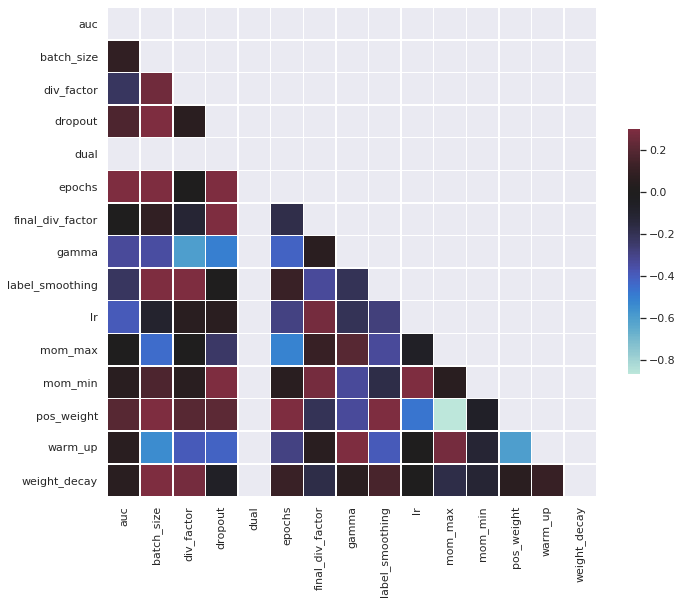

In [31]:
# Compute the correlation matrix
corr = df.corr('kendall')

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
# cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, vmax=.3, center=0, # cmap=cmap,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [37]:
files, preds, oof, scores = [], [], [], []

for f in candidates:
    score = float(os.path.basename(f)[6:-4])
    if score < 0.955:
        continue
    folder = os.path.dirname(f)
    sub_path = os.path.join(folder, 'submission.csv')
    sub = pd.read_csv(sub_path)
    print(score, sub.toxic.mean(), (sub.toxic > 0.5).mean(), sub_path)
    if sub.toxic.mean() < 0.49:
        files.append(f)
        scores.append(score)

        sub.to_csv(f'../submission_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
        preds.append(sub.toxic.values)

        valid = pd.read_csv(os.path.join(folder, 'valid_oof.csv'))
        valid.to_csv(f'../valid_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)
        oof.append(valid.pred.values)
        assert abs(roc_auc_score(valid.toxic, valid.pred) - score) < 1e-5

        params = pd.read_csv(f)
        params.to_csv(f'../params_{"_".join(folder.split("/")[-3:])}_{score}.csv', index=False)

# !ls -sh ../submission_*.csv

0.955511 0.3622144613480223 0.2539020873816837 gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/submission.csv
0.955327 0.44813851293502793 0.2800727135961888 gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/submission.csv
0.955442 0.34682769331669594 0.2254278192189557 gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/submission.csv
0.955724 0.2313057937686015 0.2110104682504858 gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/submission.csv
0.956338 0.23457636069512788 0.21629160659437097 gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/submission.csv
0.956769 0.22726137278612174 0.2301761424183539 gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/submission.csv
0.956153 0.41266451836175017 0.24741427944587224 gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/submission.csv
0.956442 0.3539857048345296 0.2475396477151633 gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/submission.csv
0.955524 0.437688493327744 0.307152259763054 gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/submission.csv


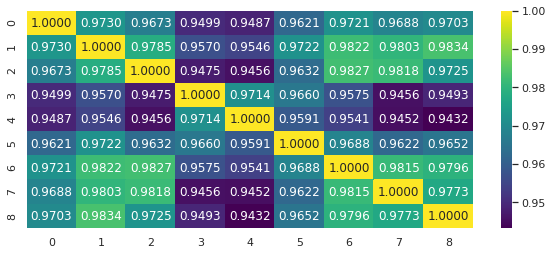

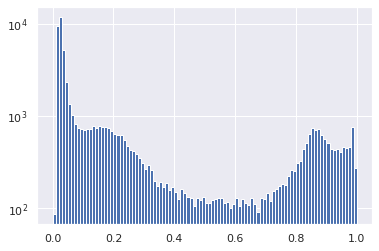

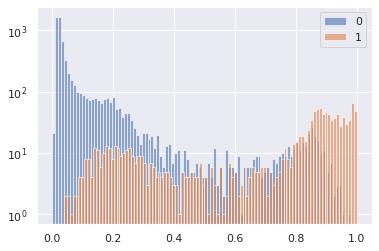

AUC: 0.9574942056658381 toxic: 0.15375 pred: 0.20297790759326625 ratio: 0.16525
mean score: 0.9559144444444444


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 0.11419054604954515,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 0.08681098616425555,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 0.10350189276649674,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.14112476658716738,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.14997696366364352,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.11158311867745392,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 0.08786958844085206,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.10210744551306085,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 0.10283469213752484}

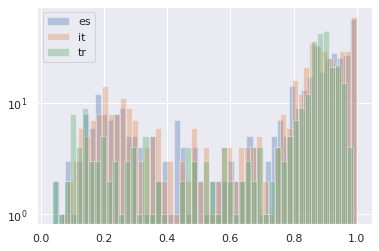

In [40]:
corr_mat = np.corrcoef(preds)
# print(corr_mat)

weights = (1-corr_mat).sum(axis=0) # gain
weights /= weights.sum()

fig, ax = plt.subplots(figsize=(len(preds)+1, len(preds)//2))
ax = sns.heatmap(corr_mat, cmap='viridis', annot=True, fmt="0.04f", ax=ax)
plt.show()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
sub.toxic -= sub.toxic.min()
sub.toxic /= sub.toxic.max()
valid['pred'] = np.average(oof, weights=weights, axis=0)
valid.pred -= valid.pred.min()
valid.pred /= valid.pred.max()

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_decorr{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_decorr{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

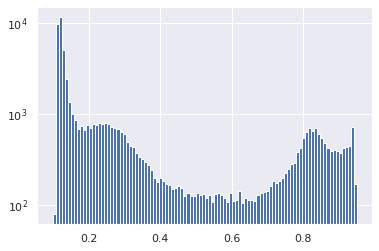

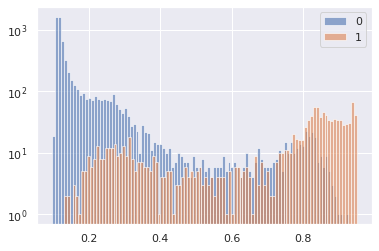

AUC: 0.9575158218347323 toxic: 0.15375 pred: 0.2701708645138708 ratio: 0.168375
mean score: 0.9559144444444444


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 0.11008982335267752,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 0.10963638329947113,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 0.10991934447545383,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.1106194360632684,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.11217502980022154,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.11329338093352613,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 0.11170173902746537,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.11244286126859065,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 0.11012200177932537}

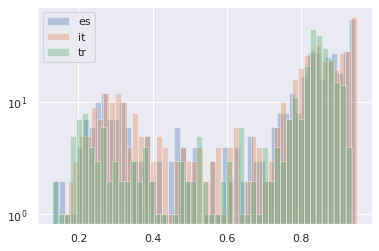

In [41]:
# weight by score
weights = 1 / (1-np.array(scores))
weights /= weights.sum()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
valid['pred'] = np.average(oof, weights=weights, axis=0)

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_score_blend{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_score_blend{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

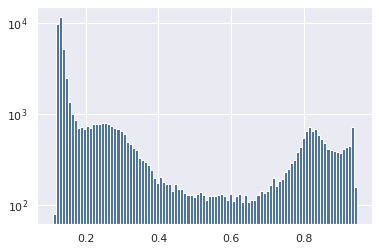

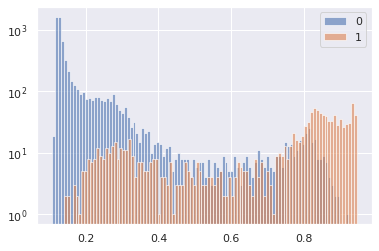

AUC: 0.9575066950078658 toxic: 0.15375 pred: 0.27803080351527726 ratio: 0.16925
mean score: 0.9559144444444444


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.1111111111111111,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 0.1111111111111111}

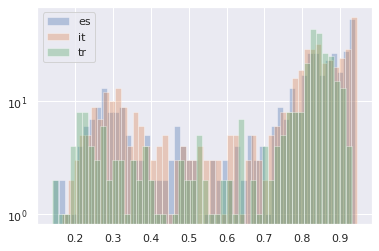

In [42]:
# average
weights = np.ones_like(scores)
weights /= weights.sum()

sub['toxic'] = np.average(preds, weights=weights, axis=0)
valid['pred'] = np.average(oof, weights=weights, axis=0)

ax = sub.toxic.hist(bins=100, log=True)
plt.show()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.6)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.35)
plt.legend(valid.lang.unique())

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))

sub.to_csv(f'../submission_avg{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_avg{len(preds)}_{valid_auc:.04f}.csv', index=False)

{f:w for f,w in zip(files, weights)}

shapes: (8000, 10) (8000,)
   Iteration        Cost      Cost reduction    Step norm     Optimality   
       0         2.5782e+04                                    7.30e+03    
       1         5.9991e+03      1.98e+04       1.10e+00       1.82e+03    
       2         1.4246e+03      4.57e+03       5.45e-01       4.49e+02    
       3         4.5777e+02      9.67e+02       2.64e-01       1.11e+02    
       4         2.8813e+02      1.70e+02       1.15e-01       2.76e+01    
       5         2.5810e+02      3.00e+01       7.39e-02       1.23e+01    
       6         2.4412e+02      1.40e+01       2.16e-01       2.18e+00    
       7         2.4082e+02      3.30e+00       1.71e-01       4.06e-01    
       8         2.3999e+02      8.27e-01       6.81e-02       8.21e-02    
       9         2.3970e+02      2.94e-01       2.55e-02       1.64e-01    
      10         2.3967e+02      3.29e-02       5.48e-03       2.05e-03    
      11         2.3967e+02      1.12e-04       3.65e-05     

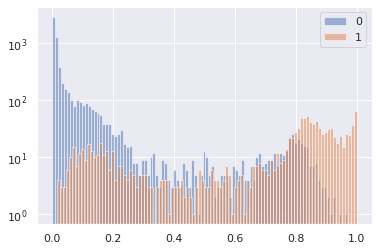

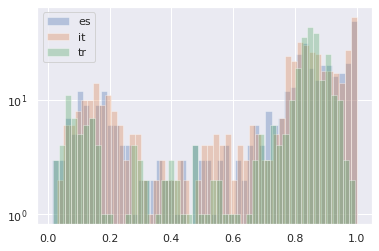

AUC: 0.9574263549134754 toxic: 0.15375 pred: 0.17421199825706565 ratio: 0.16275
mean score: 0.9559144444444444
top score: 0.956769 5 0.9567685028401245
0.3849490227993062
0


{'gs://hm-eu-w4/jigsaw/s08/20200515_114050_t2d/params0.955511.csv': 4.408574013323907e-34,
 'gs://hm-eu-w4/jigsaw/s08/20200515_200937_t2d/params0.955327.csv': 3.28178462523585e-31,
 'gs://hm-eu-w4/jigsaw/s08/20200515_211937_t2b/params0.955442.csv': 5.506542445410801e-41,
 'gs://hm-eu-w4/jigsaw/s08/20200515_221332_t2d/params0.955724.csv': 0.21501630306892977,
 'gs://hm-eu-w4/jigsaw/s08/20200516_000921_t2c/params0.956338.csv': 0.05419156223222812,
 'gs://hm-eu-w4/jigsaw/s08/20200516_002443_t2d/params0.956769.csv': 0.5839400942708689,
 'gs://hm-eu-w4/jigsaw/s08/20200516_023728_t2d/params0.956153.csv': 4.653046745639562e-31,
 'gs://hm-eu-w4/jigsaw/s08/20200516_110211_t2d/params0.956442.csv': 0.058664949722203964,
 'gs://hm-eu-w4/jigsaw/s08/20200516_125815_t2c/params0.955524.csv': 1.6601516120617973e-31}

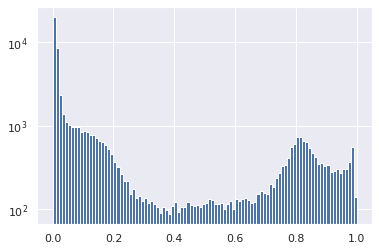

In [43]:
from scipy.optimize import lsq_linear

bias = np.ones_like(oof[0]).tolist()
A = np.stack(oof + [bias]).T.copy()
# A = np.stack(oof).T.copy()
b = valid.toxic.values.copy()
print('shapes:', A.shape, b.shape)

res = lsq_linear(A, b, bounds=(0, 1), lsq_solver='exact', method='trf', tol=1e-15, verbose=2)
print(res)
best_weights = res.x
valid_preds = A.dot(best_weights)
print('MSE:', mean_squared_error(b, valid_preds))
print('AUC:', roc_auc_score(b, valid_preds))
print('Sum of weights:', sum(best_weights))

valid['pred'] = valid_preds
valid.pred -= valid.pred.min()
valid.pred /= valid.pred.max()

ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
plt.legend([0, 1])
plt.show()

ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
plt.legend(valid.lang.unique())
plt.show()

valid_auc = roc_auc_score(valid.toxic, valid.pred)
print('AUC:', valid_auc,
      'toxic:', valid.toxic.mean(),
      'pred:', valid.pred.mean(),
      'ratio:', (valid.pred > 0.5).mean())
print('mean score:', np.mean(scores))
top = np.argmax(best_weights[:len(preds)])
print('top score:', scores[top], top, roc_auc_score(valid.toxic, oof[top]))

sub['toxic'] = np.stack(preds).T.dot(best_weights[:len(preds)])
sub.toxic -= sub.toxic.min()
sub.toxic /= sub.toxic.max()
ax = sub.toxic.hist(bins=100, log=True)
sub.to_csv(f'../submission_lsq{len(preds)}_{valid_auc:.04f}.csv', index=False)
valid.to_csv(f'../valid_lsq{len(preds)}_{valid_auc:.04f}.csv', index=False)

bias = np.ones_like(oof[0]).tolist()
print(abs(A - np.stack(oof + [bias]).T.copy()).max())
# print(abs(A - np.stack(oof).T.copy()).mean())
print(abs(b - valid.toxic.values.copy()).max())

{f:w for f,w in zip(files, best_weights[:len(preds)])}

# Remove low scoring and incomplete models 

In [38]:
import tensorflow as tf
import pandas as pd

# clean up
folders = 'gs://hm-eu-w4/jigsaw/*/*/*'
models = []
for f in tf.io.gfile.glob(folders):
    n_items = len(tf.io.gfile.glob(os.path.join(f, 'best_model.tf*')))
    if n_items > 0:
        params = tf.io.gfile.glob(os.path.join(f, 'params*.csv'))
        if len(params) == 0:
            print(f, n_items, tf.io.gfile.glob(os.path.join(f, '*')))
            !gsutil -m rm -r {f}
        else:
            score = float(os.path.basename(params[0])[6:-4])
            print(f, n_items, len(tf.io.gfile.glob(os.path.join(f, '*'))), score)
            if score < 0.955:
                !gsutil -m rm -r {f}
            else:
                models.append(f.split('/')[-3:-1] + [score])
#     elif n_items == 0:
#         !gsutil rm -r {f}

gs://hm-eu-w4/jigsaw/bt05/20200506_194600_t8d/ 3 12 0.95527
gs://hm-eu-w4/jigsaw/bt05/20200506_215624_t8b/ 3 12 0.955373
gs://hm-eu-w4/jigsaw/bt05/20200507_160433_t8d/ 3 12 0.955986
gs://hm-eu-w4/jigsaw/bt05/20200508_214456_t8b/ 3 12 0.955258
gs://hm-eu-w4/jigsaw/bt05/20200509_101452_t8d/ 3 12 0.956088
gs://hm-eu-w4/jigsaw/bt05/20200509_122405_t8d/ 3 12 0.955531
gs://hm-eu-w4/jigsaw/bt05/20200509_212548_t8d/ 3 12 0.955396
gs://hm-eu-w4/jigsaw/bt05/20200509_230445_t8d/ 3 12 0.955231
gs://hm-eu-w4/jigsaw/s06/20200512_071944_t8c/ 3 12 0.961078
gs://hm-eu-w4/jigsaw/s06/20200512_081548_t8b/ 3 12 0.959556
gs://hm-eu-w4/jigsaw/s06/20200512_102018_t8b/ 3 12 0.959827
gs://hm-eu-w4/jigsaw/s06/20200512_114608_t8c/ 3 12 0.959633
gs://hm-eu-w4/jigsaw/s06/20200512_125203_t8b/ 3 12 0.959691
gs://hm-eu-w4/jigsaw/s06/20200512_173316_t8d/ 3 12 0.959693
gs://hm-eu-w4/jigsaw/s06/20200512_193447_t8d/ 3 12 0.960449
gs://hm-eu-w4/jigsaw/s06/20200512_211728_t8b/ 3 12 0.960184
gs://hm-eu-w4/jigsaw/s06/20200512

In [39]:
df = pd.DataFrame(models, columns=['type', 'id', 'auc'])
df.groupby('type').describe()

auc                                                              \
     count      mean       std       min       25%       50%       75%   
type                                                                     
bt05   8.0  0.955517  0.000336  0.955231  0.955267  0.955385  0.955645   
s06   13.0  0.960019  0.000463  0.959556  0.959691  0.959827  0.960184   
s07   16.0  0.961099  0.000630  0.960277  0.960619  0.961121  0.961547   
s08    9.0  0.955914  0.000520  0.955327  0.955511  0.955724  0.956338   
t03    1.0  0.957579       NaN  0.957579  0.957579  0.957579  0.957579   
t04    4.0  0.960909  0.000846  0.959791  0.960608  0.961009  0.961310   
t05   14.0  0.960762  0.000679  0.959954  0.960227  0.960592  0.961206   
t12    9.0  0.960647  0.000625  0.960124  0.960299  0.960400  0.960744   

                
           max  
type            
bt05  0.956088  
s06   0.961078  
s07   0.962582  
s08   0.956769  
t03   0.957579  
t04   0.961828  
t05   0.961848  
t12   0.962192

In [49]:
# import pdb; pdb.pm()